In [236]:
from sortedcontainers import SortedList
from math import log, exp, sqrt
from random import random, randrange
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [170]:
sl = SortedList()

In [171]:
# NOTE 1 << i = 2^i

# q[i] = p[2^i - 1]
def build_envelope(sl, q, eta):
    logK = len(q)
    for i in range(logK):
        q[i] = exp(-eta*sl[(1 << i)-1][0])  

# returns an arm using rejection sampling
# example to keep in mind:
# \tilde{p} = (8, 7, 6, 5, 4, 3, 2, 1)
# \tilde{q} = (8, 8, 7, 7, 5, 5, 5, 5)
# bucket    = (0____ 1____ 2_________)
# q = (8, 7, 5) 
def sample(q, sl):
    logK = len(q)
    
    # Compute normalizing constant of q
    Z = 2.0*q[0]
    for i in range(1, logK):
        Z += q[i]*(1 << i)
        
    # Rejection while loop
    while True:
        # First we draw a random bucket
        u = random()
        bucket = None
        cdf = 2*q[0]
        if u < cdf/Z:
            bucket = 0
        if not bucket:
            for i in range(1, logK):
                cdf += q[i]*(1 << i)
                if u < cdf/Z:
                    bucket = i
                    break
        if not bucket:
            print("Error: bucket not assigned")
            return 

        # We draw the arm uniformly within the bucket. Draw = k means we drew the k-th largest arm
        if bucket == 0:
            draw = randrange(2)
        else:
            draw = (1 << bucket) + randrange(1 << bucket)
            
        # Rejection step
        if random() < exp(-eta*sl[draw][0])/(2.0*exp(-eta*q[bucket])):
            return sl[draw]
        
def sample_envelope(q):
    logK = len(q)
    
    # Compute normalizing constant of q
    Z = 2.0*q[0]
    for i in range(1, logK):
        Z += q[i]*(1 << i)
        
    # First we draw a random bucket
    u = random()
    bucket = None
    cdf = 2*q[0]
    if u < cdf/Z:
        bucket = 0
    if not bucket:
        for i in range(1, logK):
            cdf += q[i]*(1 << i)
            if u < cdf/Z:
                bucket = i
                break
    if not bucket:
        print("Error: bucket not assigned")
        return 

    # We draw the arm uniformly within the bucket. Draw = k means we drew the k-th largest arm
    if bucket == 0:
        draw = randrange(2)
    else:
        draw = (1 << bucket) + randrange(1 << bucket)
    return draw, q[bucket]/Z

# Comparing algos
### Details: There are K arms. A fixed number frac*K of the arms return a uniform random loss and the remaining (1-frac)*K arms return 0 loss. 

In [356]:
logK = 25
T = 1
frac = 0.1
regret = np.zeros((T, 2))

## Modified EXP3

In [354]:
sl.clear()
sl.update([(0,i) for i in range(1 << logK)])
q = [None]*logK

eta = sqrt(logK/(2.0*T*(1 << logK)))
start = time()
for t in range(T):
    build_envelope(sl, q, eta)
    L, arm = sample(q, sl)
    
    # Make arms 0, 1, ..., frac*K have unuiform loss, rest is 0
    loss = random() if arm < (1 << logK)*frac else 0
    regret[t][0] = (0 if t==0 else regret[t-1][0]) + loss
    
    # J is not the true index, but indexed according to the sorted order
    J, q_prob = sample_envelope(q)
    dL = loss*exp(-eta*sl[J][0])/(exp(-eta*L)*q_prob)
    sl.remove((L, arm))
    sl.add((L+dL, arm))
avg = (time() - start)/T
print("Average time per iteration is {}".format(avg))
print("Total time was {}".format(avg*T))

Average time per iteration is 7.25554943085e-05
Total time was 0.725554943085


## EXP3

In [357]:
eta = sqrt(2*logK/float(T*(1 << logK)))
regret_EXP = [0]*T
L = [0]*(1 << logK)
p = [1/float(1 << logK)]*(1 << logK)
s = float(1 << logK)
start = time()
for t in range(T):
    arm = np.random.choice(range(1 << logK), 1, p = p)[0]
    loss = random() if arm < (1 << logK)*frac else 0
    regret[t][1] = (0 if t==0 else regret[t-1][1]) + loss
    s -= exp(-eta*L[arm])
    L[arm] += loss/p[arm]
    s += exp(-eta*L[arm])
#     s = np.sum(map(lambda x: exp(-eta*x), L))
    for i in range(1 << logK):
        p[i] = exp(-eta*L[i])/s
avg = (time() - start)/T
print("Average time per iteration is {}".format(avg))
print("Total time was {}".format(avg*T))

Average time per iteration is 6.6151008606
Total time was 6.6151008606


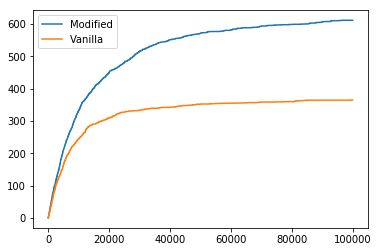

In [335]:
plt.plot(regret)
plt.legend(['Modified', 'Vanilla'])